# Sleep Stage Scoring (on raw EEG signal)

What is different from [this version](https://github.com/baroquerock/sleep-stages-scoring):
1. Pytorch framework
2. Multichannel input
3. Different architecture

New architecture accomodates two channels:

<img src="img/arch2.png" width="800" height="1000">

In [206]:
import random
import numpy as np
import pandas as pd
import os
import re
import copy
import time

import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from torchvision import transforms, datasets, models

from collections import OrderedDict

from npzloader import DataLoader as DataLoader_x
import torch.utils.data as utils

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (confusion_matrix, classification_report, cohen_kappa_score)

from hmmlearn.hmm import MultinomialHMM

import warnings

warnings.filterwarnings("ignore")

In [207]:
# loading fpz_cz and pz_oz channels
loader = DataLoader_x("../data/eeg_fpz_cz")
data_fp, labels = loader.load_data(verbose=0)
data_fp = {''.join(k.partition('fpz_cz')[1:]) : v for k, v in data_fp.items()} 

loader = DataLoader_x("../data/eeg_pz_oz")
data_pz, _ = loader.load_data(verbose=0)
data_pz = {''.join(k.partition('pz_oz')[1:]) : v for k, v in data_pz.items()} 

all_labels = np.hstack(labels.values())

In [208]:
# Sleep stages values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4

# int-to-label map
class_dict = {W: "W", 
              N1: "N1",
              N2: "N2",
              N3: "N3",
              REM: "REM"}

TEST_SUBJECT_INDEX = "19"
TEST_SUBJECT_FILE_PREFIX = f"SC4{TEST_SUBJECT_INDEX}"

### TRAINING
___

In [209]:
"""
Function to randomly select subjects for partial cross-validation and prepare the data for training.
Train and test sets should be independent.
A patient with is SC413 is excluded from any test set because this patient has only one recording.
"""
def get_cv_data(data, labels, n_folds=3, ch='fpz_cz'):
    
    random.seed(29)
    test_key = []
    keys = list(labels.keys())
    keys = list(set([x[:5] for x in keys if '413' not in x]))
    for i in range(len(keys)):
        if f"4{TEST_SUBJECT_INDEX}" in keys[i]: ### TEMP
            test_key = [keys[i]]
    random.shuffle(keys)
    print(test_key)
    val_keys = keys[:n_folds]
 
    cv_data = []
    test_key = [test_key[0] + '1E0',test_key[0] + '2E0']
    
    for fold in val_keys:
        fold_keys = [fold+'1E0', fold+'2E0']
        
        val_labels = [labels[key] for key in fold_keys]
        val_labels = np.hstack(val_labels)
        
        keys_not_training = fold_keys + test_key
        
        train_labels = [labels[key] for key in labels.keys() if key not in keys_not_training]
        train_labels = np.hstack(train_labels)
       
        test_labels=[labels[key] for key in test_key]
        test_labels= np.hstack(test_labels)
        
        if ch:
            val_data = [data['{}/{}'.format(ch,key)] for key in fold_keys]
            train_data = [data['{}/{}'.format(ch,key)] for key in labels.keys() if key not in keys_not_training]   
            test_data = [data['{}/{}'.format(ch,key)] for key in test_key]
        else:
            val_data = [data[key] for key in fold_keys]
            train_data = [data[key] for key in labels.keys() if key not in keys_not_training]
            test_data = [data[key] for key in labels.keys() if key in test_key]
           
        train_data = np.vstack(train_data)
        val_data = np.vstack(val_data)
        test_data = np.vstack(test_data)
    
        cv_data.append((train_data, train_labels, val_data, val_labels, test_data, test_labels))
    
    return cv_data 

"""
Function to slide on array with a moving window of size n
"""

def _slide(data, labels, n=3):
    
    #zero-indexing
    data = [data[i:i+n] for i, _ in enumerate(data[n:])]
    data = [np.vstack(x) for x in data]
    data = np.array(data)
    
    labels = labels[n:]
    
    assert data.shape[0] == labels.shape[0]
    
    return data, labels

"""
Function to do batch processing with _slide()
"""

def batch_slide(data_dict, labels_dict, n=3):
    
    keys = [(x,y) for x,y in zip(data_dict, labels_dict)]
    data = [_slide(data_dict[x], labels_dict[y], n=n) for x,y in keys]
    
    data_keys, label_keys = zip(*keys)
    data, labels = zip(*data)
    
    data_dict = {k:v for k,v in zip(data_keys, data)}
    data_dict = OrderedDict(sorted(data_dict.items()))
    
    labels_dict = {k:v for k,v in zip(label_keys, labels)}
    labels_dict = OrderedDict(sorted(labels_dict.items()))
        
    return data_dict, labels_dict 
  
  
"""
Function to merge channels into single recording.
axis = 0: merge channels along the first dimension - (3000,1) and (3000,1) --> (6000,1)
axis = 0: merge channels along the second dimension - (3000,1) and (3000,1) --> (3000,2)
"""  
    
def merge_channels(channels, axis=0):
    
    # number of records should be the same in all channels
    assert len(set([len(r) for r in channels])) == 1
    
    keys = [ch.keys() for ch in channels]
    
    merged = {}
    
    for records in zip(*keys):
        
        # assert that all recordings are for the same patient
        assert len(set([r.split('/')[1] for r in records])) == 1
        vals = [ch[r] for r, ch in zip(records, channels)]
        if axis:
            stacked = np.dstack(vals)
        else:
            stacked = np.hstack(vals)
        patient = records[0].split('/')[1]
        merged[patient] = stacked
        
    merged = OrderedDict(sorted(merged.items()))
    return merged


In [210]:
data_all = merge_channels([data_fp, data_pz], axis=1)

In [211]:
# for key in ['SC4101E0', 'SC4102E0', 'SC4111E0', 'SC4112E0', 'SC4121E0', 'SC4122E0', 'SC4131E0', 'SC4141E0', 'SC4142E0', 'SC4151E0', 'SC4152E0', 'SC4161E0', 'SC4162E0', 'SC4171E0', 'SC4172E0', 'SC4181E0', 'SC4182E0', 'SC4191E0', 'SC4192E0']:
#     del data_all[key]
#     del labels[key]

In [216]:
# getting cross-valivation data
# note: n_folds is not a number of folds in traditional sense
# the model is trained on 19 patients and validated on 1,
# so n_folds is a number of patients for validation
# to perform full cross-validation n_folds should be equal to 19 
# (not 20, because for SC413 patient there is only one record)
cv_data = get_cv_data(data_all, labels, ch=None, n_folds=2)

['SC419']


In [217]:
def small_conv(fs): 
    return nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=fs//2, stride=fs//16, padding=2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(kernel_size=8, stride=8),
            
            nn.Conv1d(64, 64, kernel_size=8, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=8, padding=2),
            nn.ReLU(), 
            nn.Conv1d(64, 64, kernel_size=8, padding=2),
            nn.ReLU())

def big_conv(fs): 
    return nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=fs*4, stride=fs//2, padding=2),
            nn.ReLU(), 
            nn.Dropout(0.3),
            nn.MaxPool1d(kernel_size=4, stride=4),
            
            nn.Conv1d(64, 64, kernel_size=6, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=6, padding=2),
            nn.ReLU(), 
            nn.Conv1d(64, 64, kernel_size=6, padding=2),
            nn.ReLU())


class ConvNet(nn.Module):
  
    def __init__(self, n_cnn_dense=256, fs=100, num_classes=5):
      
        super(ConvNet, self).__init__()
        
        self.layer1_fz = small_conv(fs)        
        self.layer2_fz = big_conv(fs)

        self.layer1_pz = small_conv(fs)        
        self.layer2_pz = big_conv(fs)
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(124, n_cnn_dense),
            nn.ReLU(),            
            nn.MaxPool1d(kernel_size=4, stride=4))
        
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes),
            nn.LogSoftmax(dim=1))
        
                
        
    def forward(self, channels):
      
        ch1 = channels[:, 0, :].unsqueeze(1)
        ch2 = channels[:, 1, :].unsqueeze(1)
        
        out1_1 = self.layer1_fz(ch1)
        out2_1 = self.layer2_fz(ch1)
        
        out1_2 = self.layer1_pz(ch2)
        out2_2 = self.layer2_pz(ch2)        
        
        out = torch.cat((out1_1, out2_1, out1_2, out2_2), dim=2)
        out = self.fc1(out)
        s = out.size()[0]
        out = out.view(s, -1)
        out = self.fc2(out)
       
        return out

In [218]:
model = ConvNet()
train_data, train_labels, val_data, val_labels, test_data, test_labels = cv_data[1]

train = utils.TensorDataset(torch.from_numpy(np.swapaxes(train_data,1,2)), torch.from_numpy(train_labels).long())
train_loader = utils.DataLoader(train, batch_size=64, shuffle=True)

valid = utils.TensorDataset(torch.from_numpy(np.swapaxes(val_data,1,2)), torch.from_numpy(val_labels).long())
valid_loader = utils.DataLoader(valid, batch_size=64, shuffle=True)

test = utils.TensorDataset(torch.from_numpy(np.swapaxes(test_data,1,2)), torch.from_numpy(test_labels).long())
test_loader = utils.DataLoader(test, batch_size=64, shuffle=True)
                           
dataloaders = {'train': train_loader, 'valid': valid_loader, "test": test_loader}
dataset_sizes = {'train': len(train), 'valid': len(valid), "test": len(test)}

In [219]:
def train_model(model, criteria, optimizer, scheduler, num_epochs=25, device='cuda'):
    model.to(device)
    since = time.time()
    epoch_loss_array=[] 
    accuracy_array=[]
    n_stages = len(class_dict.keys())
    emission_matrices = [np.zeros((n_stages,n_stages)) for _ in range(num_epochs)]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch_idx, epoch in enumerate(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid',"test"]:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()   
                
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
   
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                for y_pred, y_true in zip(preds, labels):
                    emission_matrices[epoch_idx][y_true, y_pred] += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_loss_array.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            accuracy_array.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # keep emission matrices according to the best model (biggest accuracy)
    print(f"Best epoch is {int(np.argmax(accuracy_array)/3)}")
    emission_matrix = emission_matrices[int(np.argmax(accuracy_array)/3)]
    emission_matrix = emission_matrix / emission_matrix.sum(axis=1, keepdims=True)
    
    return model, epoch_loss_array, accuracy_array, emission_matrix

In [220]:
criteria = nn.NLLLoss() # negative log likelihood loss 
optimizer = optim.Adam(model.parameters(), lr=0.005)
sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
nb_epochs = 15 

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {}!".format(device))

model_ft,epoch_loss_array,accuracy_array,emission_matrix= train_model(model, criteria, optimizer, sched, nb_epochs, device)


Using cpu!
Epoch 1/1
----------
train Loss: 0.7060 Acc: 0.7297
valid Loss: 0.8869 Acc: 0.7132
test Loss: 0.8063 Acc: 0.6924
Training complete in 1m 51s
Best val Acc: 0.713243
Best epoch is 0


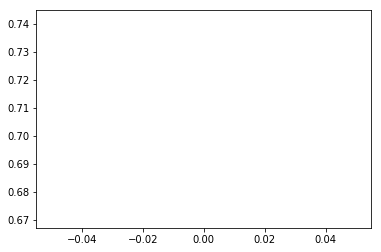

In [139]:
loss_array_train=[]
loss_array_valid=[]
loss_array_test=[]



for i in range(0, len(epoch_loss_array), 3):
    loss_array_train.append(epoch_loss_array[i])
    
for i in range(1, len(epoch_loss_array), 3):
    loss_array_valid.append(epoch_loss_array[i])

for i in range(2, len(epoch_loss_array), 3):
    loss_array_test.append(epoch_loss_array[i])
plt.plot(loss_array_train)



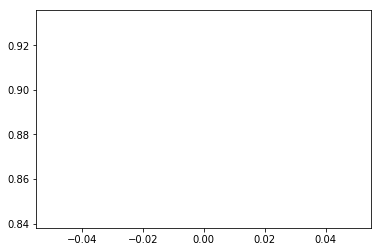

In [140]:
plt.plot(loss_array_valid)

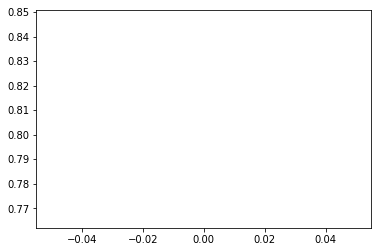

In [141]:
plt.plot(loss_array_test)

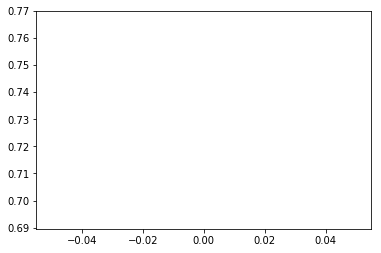

In [142]:
accuracy_array_train=[]
accuracy_array_valid=[]
accuracy_array_test=[]

for i in range(0, len(accuracy_array), 3):
    accuracy_array_train.append(accuracy_array[i])
    
for i in range(1,len(accuracy_array), 3):
    accuracy_array_valid.append(accuracy_array[i])

for i in range(2, len(accuracy_array), 3):
    accuracy_array_test.append(accuracy_array[i])
plt.plot(accuracy_array_train)


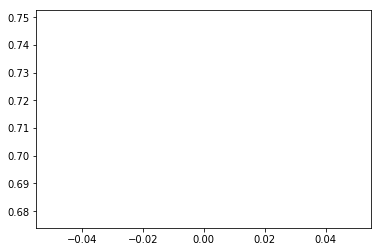

In [143]:
plt.plot(accuracy_array_valid)

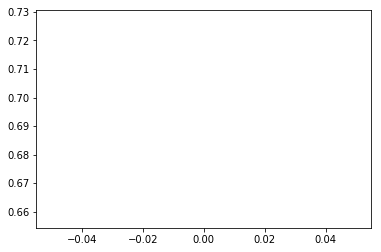

In [144]:
plt.plot(accuracy_array_test)

## Testing on our subject nights
___

In [195]:
def print_hypnogram(y, label):
    y_hypno = y

    # Tweak to make REM between N1 and W
    y_hypno[y_hypno == REM] = -1    
    y_hypno[y_hypno == N3] = REM
    y_hypno[y_hypno == N2] = N3
    y_hypno[y_hypno == N1] = N2
    y_hypno[y_hypno == -1] = N1
    # -------------------------------- #
    
    y_hypno = np.array([(index*30, stage) for index, stage in enumerate(y_hypno)])    
    
    plt.plot([y[0]/3600 for y in y_hypno], [y[1] for y in y_hypno], label=label)
    plt.xlabel("Time since bed time (hours)")
    plt.ylabel("Sleep stage")
    plt.yticks(range(5), ['W','REM','N1','N2','N3'])
    plt.legend()

In [166]:
y_test_keys = [key for key in labels if TEST_SUBJECT_FILE_PREFIX in key]
y_test_keys

['SC4091E0', 'SC4092E0']

[[ 89   1   5   6  49]
 [  1   0 109   1 121]
 [  1   0   4   0  14]
 [  7   1 460  16  77]
 [  0   0  27 143   0]]
              precision    recall  f1-score   support

           W       0.91      0.59      0.72       150
          N1       0.00      0.00      0.00       232
          N2       0.01      0.21      0.01        19
          N3       0.10      0.03      0.04       561
         REM       0.00      0.00      0.00       170

    accuracy                           0.10      1132
   macro avg       0.20      0.17      0.15      1132
weighted avg       0.17      0.10      0.12      1132

Agreement score (Cohen Kappa):  -0.036488079415073704


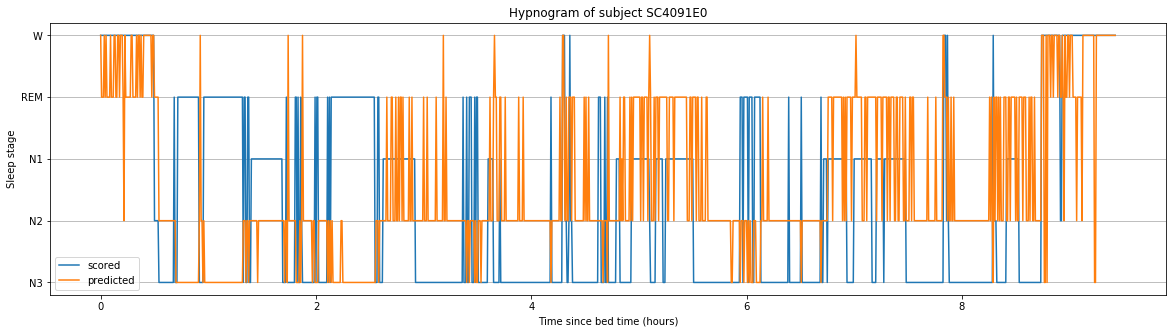

[[ 92   0  16  11  21]
 [  6   0 137   0 122]
 [ 10   0  45   4  22]
 [  0   0 415  84  13]
 [  0   0   0 107   0]]
              precision    recall  f1-score   support

           W       0.85      0.66      0.74       140
          N1       0.00      0.00      0.00       265
          N2       0.07      0.56      0.13        81
          N3       0.41      0.16      0.23       512
         REM       0.00      0.00      0.00       107

    accuracy                           0.20      1105
   macro avg       0.27      0.28      0.22      1105
weighted avg       0.30      0.20      0.21      1105

Agreement score (Cohen Kappa):  0.05322495914644665


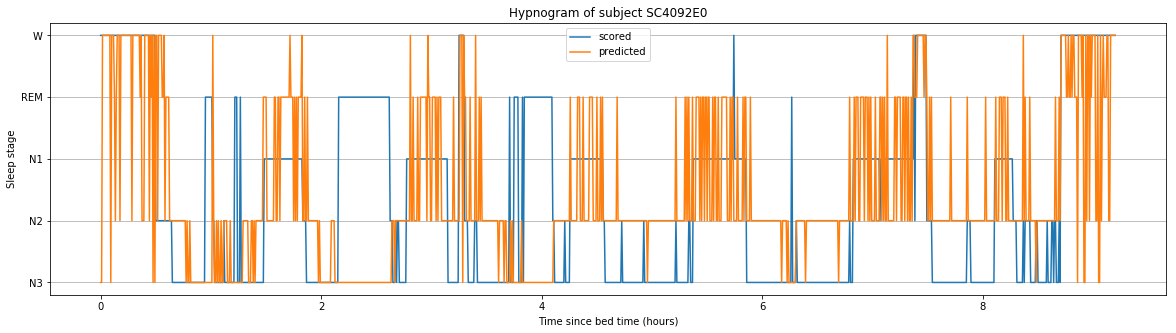

In [200]:
plt.rcParams["figure.figsize"] = (20,5)

for night_key in y_test_keys:
    y_test_current = labels[night_key]
    curent_eeg_data = np.swapaxes(data_all[night_key], 1, 2) 
    current_eeg_tensor = torch.from_numpy(curent_eeg_data)

    output = model_ft(current_eeg_tensor)
    _, y_test_current_pred = torch.max(output, 1)
    y_test_current_pred = y_test_current_pred.numpy()
    
    print(confusion_matrix(y_test_current, y_test_current_pred))

    print(classification_report(y_test_current, y_test_current_pred, target_names=class_dict.values()))

    print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y_test_current, y_test_current_pred))
    
    print_hypnogram(y_test_current, label="scored")
    print_hypnogram(y_test_current_pred, label="predicted")

    plt.title(f"Hypnogram of subject {night_key}")
    plt.grid(axis='y')
    plt.gca().invert_yaxis()
    plt.show()

## Hidden Markov Model
___

We add a hidden markov model as a postprecessing step to take into account the data's normal transi

In [150]:
y_train_valid_keys = [key for key in labels if TEST_SUBJECT_FILE_PREFIX not in key]
y_train_valid_keys

['SC4001E0',
 'SC4002E0',
 'SC4011E0',
 'SC4012E0',
 'SC4021E0',
 'SC4022E0',
 'SC4031E0',
 'SC4032E0',
 'SC4041E0',
 'SC4042E0',
 'SC4051E0',
 'SC4052E0',
 'SC4061E0',
 'SC4062E0',
 'SC4071E0',
 'SC4072E0',
 'SC4081E0',
 'SC4082E0']

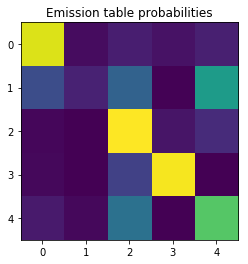

In [163]:
plt.title("Emission table probabilities")
plt.imshow(emission_matrix)

In [202]:
n_components = len(class_dict.keys())

def compute_hmm_matrices(y_train_valid_keys):
    transition_matrix = np.zeros((n_components,n_components))
    start_matrix = np.zeros((n_components))

    for night_key in y_train_valid_keys:
        print(f"Computing file: {night_key}")
        current_y = labels[night_key]
        start_matrix[current_y[0]] += 1

        for transition in zip(current_y[:-1], current_y[1:]):
            transition_matrix[transition[0], transition[1]] += 1
            
    transition_matrix = transition_matrix/transition_matrix.sum(axis=1, keepdims=True)
    start_matrix = start_matrix/start_matrix.sum()
    
    return transition_matrix, start_matrix
    
transition_matrix, start_matrix = compute_hmm_matrices(y_train_valid_keys)

Computing file: SC4001E0
Computing file: SC4002E0
Computing file: SC4011E0
Computing file: SC4012E0
Computing file: SC4021E0
Computing file: SC4022E0
Computing file: SC4031E0
Computing file: SC4032E0
Computing file: SC4041E0
Computing file: SC4042E0
Computing file: SC4051E0
Computing file: SC4052E0
Computing file: SC4061E0
Computing file: SC4062E0
Computing file: SC4071E0
Computing file: SC4072E0
Computing file: SC4081E0
Computing file: SC4082E0


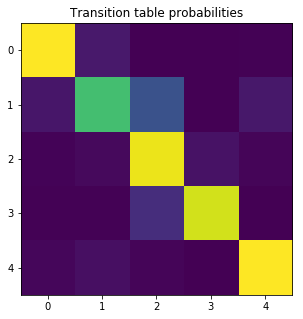

In [203]:
plt.title("Transition table probabilities")
plt.imshow(transition_matrix)

In [204]:
hmm_model = MultinomialHMM(n_components=n_components)

hmm_model.transmat_ = transition_matrix
hmm_model.startprob_ = start_matrix
hmm_model.emissionprob_ = emission_matrix

[[104   6   2   0  38]
 [  0   0  32 138   0]
 [  0   0  86   0 146]
 [  2   6   2   0   9]
 [  1   4 455  19  82]]
              precision    recall  f1-score   support

           W       0.97      0.69      0.81       150
          N1       0.00      0.00      0.00       170
          N2       0.15      0.37      0.21       232
          N3       0.00      0.00      0.00        19
         REM       0.30      0.15      0.20       561

    accuracy                           0.24      1132
   macro avg       0.28      0.24      0.24      1132
weighted avg       0.31      0.24      0.25      1132

Agreement score (Cohen Kappa):  -0.0020462527225042493


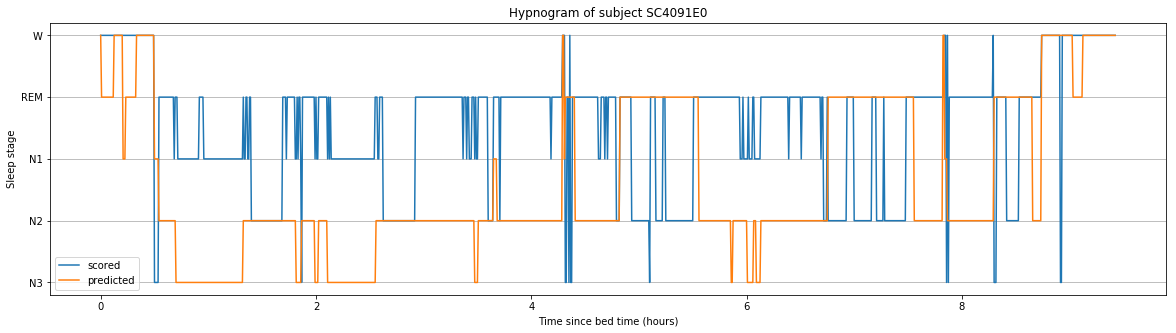

[[135   0   2   0   3]
 [  0   0   0 107   0]
 [  0   8  92   0 165]
 [  7  11  56   5   2]
 [  0   1 420  91   0]]
              precision    recall  f1-score   support

           W       0.95      0.96      0.96       140
          N1       0.00      0.00      0.00       107
          N2       0.16      0.35      0.22       265
          N3       0.02      0.06      0.04        81
         REM       0.00      0.00      0.00       512

    accuracy                           0.21      1105
   macro avg       0.23      0.27      0.24      1105
weighted avg       0.16      0.21      0.18      1105

Agreement score (Cohen Kappa):  -0.02138019973064309


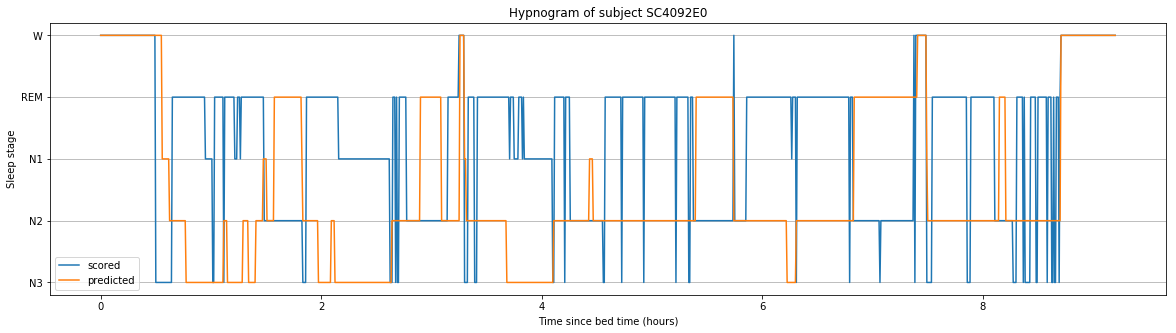

In [205]:
plt.rcParams["figure.figsize"] = (20,5)

for night_key in y_test_keys:
    y_test_current = labels[night_key]
    curent_eeg_data = np.swapaxes(data_all[night_key], 1, 2) 
    current_eeg_tensor = torch.from_numpy(curent_eeg_data)

    output = model_ft(current_eeg_tensor)
    _, y_test_current_pred = torch.max(output, 1)
    y_test_current_pred = y_test_current_pred.numpy()

    y_cnn_hmm_pred = hmm_model.predict(y_test_current_pred.reshape(-1, 1))
    
    print(confusion_matrix(y_test_current, y_cnn_hmm_pred))

    print(classification_report(y_test_current, y_cnn_hmm_pred, target_names=class_dict.values()))

    print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y_test_current, y_cnn_hmm_pred))
    
    print_hypnogram(y_test_current, label="scored")
    print_hypnogram(y_cnn_hmm_pred, label="predicted")

    plt.title(f"Hypnogram of subject {night_key}")
    plt.grid(axis='y')
    plt.gca().invert_yaxis()
    plt.show()